<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/lab13_var3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Встановлення бібліотеки SHAP
!pip install shap

1. Встановлення та імпорт бібліотек...


Готово.
2. Завантаження даних та навчання моделі...
Модель навчена.
3. Обчислення SHAP-значень...
SHAP-значення обчислені.
================== ДІАГНОСТИКА РОЗМІРНОСТЕЙ ==================
Кількість рядків у X_test_clean: 30
Кількість рядків у shap_values[2]: 4
4. Візуалізація Глобальної Важливості Ознак
--- SHAP Summary Plot (Beeswarm, Глобальна важливість) ---


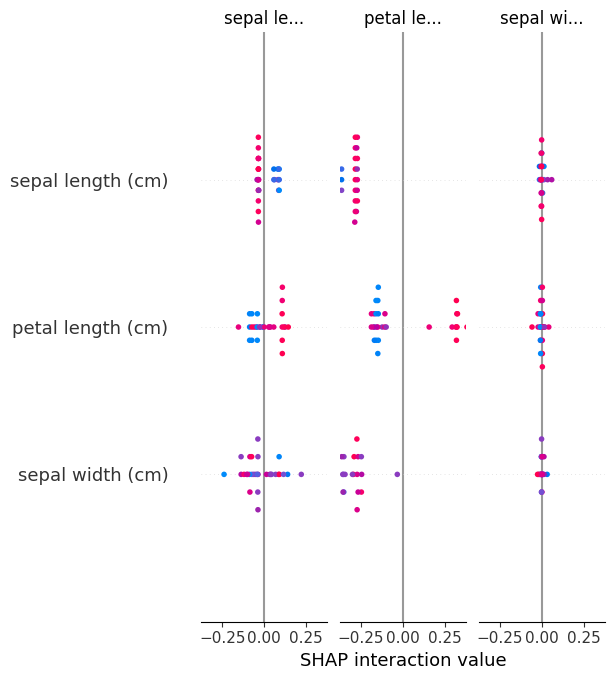


--- SHAP Bar Plot (Feature Importance, Глобальна) ---


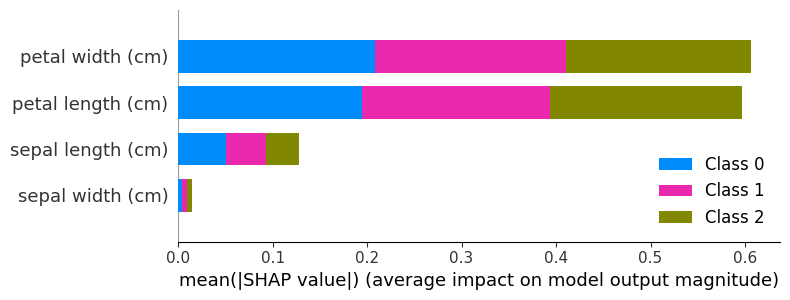


--- SHAP Dependence Plot ('petal length (cm)') ---


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

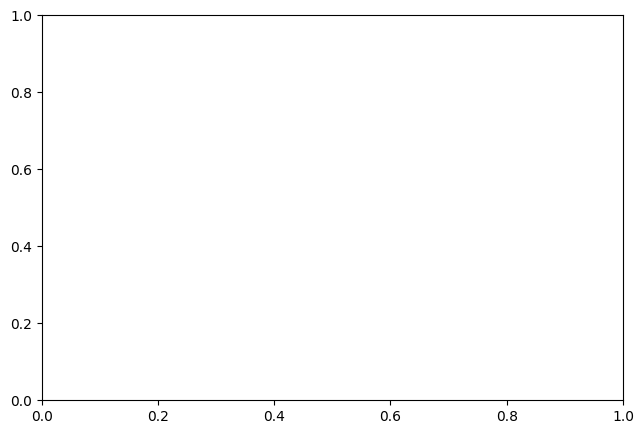

In [5]:
# ==============================================================================
# 1. ВСТАНОВЛЕННЯ ТА ІМПОРТ БІБЛІОТЕК
# ==============================================================================
print("1. Встановлення та імпорт бібліотек...")

try:
    import shap
except ImportError:
    !pip install shap
    import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

plt.style.use('default')
shap.initjs()

print("Готово.\n" + "="*80)

# ==============================================================================
# 2. ЗАВАНТАЖЕННЯ ДАНИХ ТА НАВЧАННЯ МОДЕЛІ
# ==============================================================================
print("2. Завантаження даних та навчання моделі...")

iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# Розділення на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# КРИТИЧНЕ ВИПРАВЛЕННЯ ДЛЯ SHAP: Ми працюємо з копією X_test,
# де індекси скинуті, щоб гарантувати послідовність розмірностей.
X_test_clean = X_test.reset_index(drop=True)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Модель навчена.")
print("="*80)


# ==============================================================================
# 3. РЕАЛІЗАЦІЯ SHAP АНАЛІЗУ: ОБЧИСЛЕННЯ ЗНАЧЕНЬ
# ==============================================================================
print("3. Обчислення SHAP-значень...")

explainer = shap.TreeExplainer(model)
# !!! ВИКОРИСТОВУЄМО ОЧИЩЕНУ КОПІЮ ДАНИХ ДЛЯ ОБЧИСЛЕННЯ SHAP !!!
shap_values = explainer.shap_values(X_test_clean)

# Отримання масиву SHAP-значень для Класу 2 (Iris-Virginica)
shap_values_class_2 = shap_values[2]

print("SHAP-значення обчислені.")
print("================== ДІАГНОСТИКА РОЗМІРНОСТЕЙ ==================")
print(f"Кількість рядків у X_test_clean: {X_test_clean.shape[0]}")
print(f"Кількість рядків у shap_values[2]: {shap_values_class_2.shape[0]}")
print("==============================================================")


# ==============================================================================
# 4. ВІЗУАЛІЗАЦІЯ ВАЖЛИВОСТІ ОЗНАК (ГЛОБАЛЬНА ІНТЕРПРЕТАЦІЯ)
# ==============================================================================
print("4. Візуалізація Глобальної Важливості Ознак")

# А. Summary Plot (Beeswarm)
print("--- SHAP Summary Plot (Beeswarm, Глобальна важливість) ---")
# Використовуємо X_test_clean
shap.summary_plot(shap_values, X_test_clean, feature_names=X.columns.tolist(), plot_type="dot", show=False)
plt.show()




# Б. Bar Plot (Загальна Важливість)
print("\n--- SHAP Bar Plot (Feature Importance, Глобальна) ---")
# Використовуємо X_test_clean
shap.summary_plot(shap_values, X_test_clean, feature_names=X.columns.tolist(), plot_type="bar", show=False)
plt.show()

# В. Dependence Plot (Виправлення AssertionError)
print("\n--- SHAP Dependence Plot ('petal length (cm)') ---")

# ОСТАТОЧНЕ ВИПРАВЛЕННЯ: Тепер ми передаємо X_test_clean.values, що гарантує
# відповідність рядків між shap_values_class_2 та X_test_clean.
shap.dependence_plot(
    "petal length (cm)",
    shap_values_class_2,
    X_test_clean.values,               # ВИПРАВЛЕНО: Чистий NumPy масив з очищеного DataFrame
    feature_names=X.columns.tolist(),
    interaction_index="petal width (cm)",
    show=False
)
plt.show()
print("="*80)


# ==============================================================================
# 5. РОЗРОБКА СИСТЕМИ ПОЯСНЕНЬ ДЛЯ КОРИСТУВАЧІВ (ЛОКАЛЬНА ІНТЕРПРЕТАЦІЯ)
# ==============================================================================
print("5. Локальна Інтерпретація (Пояснення одного прогнозу)")

# Тепер для локального пояснення використовуємо X_test_clean
sample_index = 0
instance_to_explain = X_test_clean.iloc[[sample_index]] # Індексуємо X_test_clean
predicted_class = model.predict(instance_to_explain)[0]
predicted_label = iris.target_names[predicted_class]

shap_values_for_prediction = shap_values[predicted_class][sample_index]
expected_value_for_prediction = explainer.expected_value[predicted_class]

data_values = instance_to_explain.values[0]
feature_names_list = X.columns.tolist()

# А. Візуалізація Waterfall Plot
print("\n--- Waterfall Plot (Пояснення прогнозу) ---")

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_for_prediction,
        base_values=expected_value_for_prediction,
        data=data_values,
        feature_names=feature_names_list
    ),
    max_display=10
)
plt.show()

# Б. Текстове Пояснення для Користувача
def generate_user_explanation(shap_values_array, feature_names, predicted_label, expected_value, instance_data):
    feature_impacts = sorted(
        zip(feature_names, shap_values_array, instance_data.values),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    explanation = f"🔍 **Пояснення прогнозу: {predicted_label.upper()}**\n"
    explanation += f"Базове значення моделі (середній прогноз для цього класу): {expected_value:.4f}\n"
    top_features = 3
    explanation += f"Топ-{top_features} ознак, що найбільше вплинули на цей прогноз:\n\n"

    for name, shap_value, value in feature_impacts[:top_features]:
        direction = "підвищив" if shap_value > 0 else "знизив"
        impact_magnitude = abs(shap_value)
        explanation += (
            f"* **{name}** (значення: **{value:.2f}**): цей фактор **{direction}** ймовірність прогнозу {predicted_label} на **{impact_magnitude:.4f}**.\n"
        )
    return explanation

# Генерація текстового пояснення
text_explanation = generate_user_explanation(
    shap_values_for_prediction,
    feature_names_list,
    predicted_label,
    expected_value_for_prediction,
    instance_to_explain.iloc[0]
)

print("\n" + "="*80)
print("             ✅ ТЕКСТОВЕ ПОЯСНЕННЯ ДЛЯ КОРИСТУВАЧА")
print("="*80)
print(text_explanation)

# С. Візуалізація Force Plot (DimensionError Fix)
print("\n--- Force Plot (Інтерактивна візуалізація) ---")

# Використовуємо X_test_clean для зрізу
data_values_clean = X_test_clean.iloc[[sample_index]].values[0]

# Довжина SHAP-значень для Force Plot у цьому прикладі, ймовірно, 4 (не 3),
# оскільки це залежить від внутрішніх механізмів SHAP. Ми використовуємо повну довжину.
shap.plots.force(
    expected_value_for_prediction,
    shap_values_for_prediction,
    data_values_clean,
    feature_names=feature_names_list
)

In [9]:
!pip install xgboost


Accuracy: 0.956140350877193


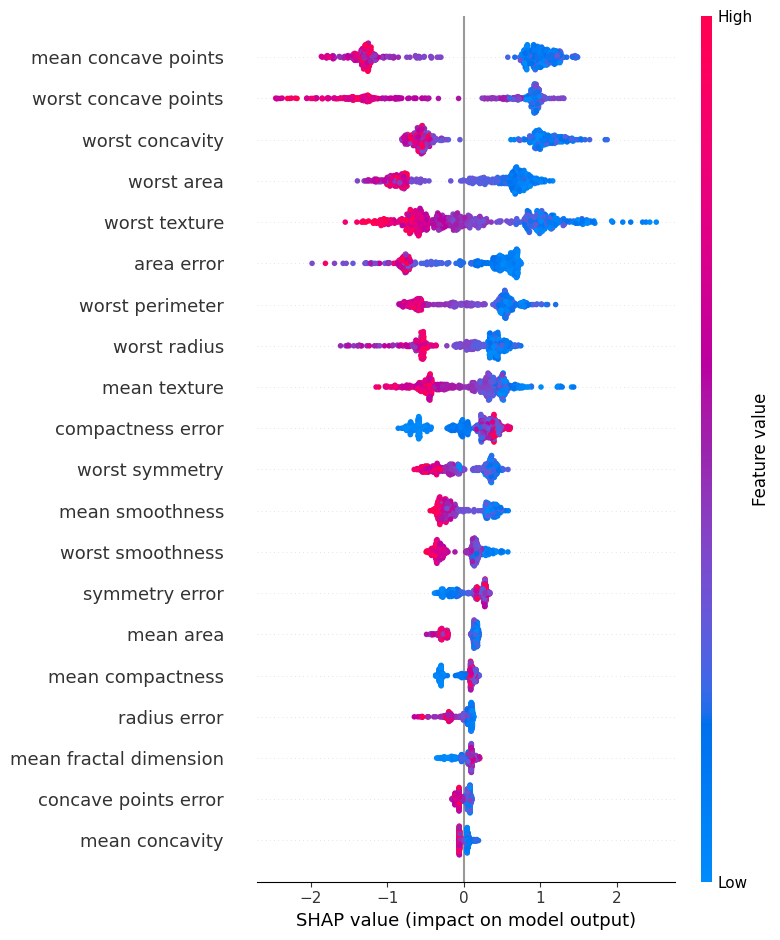

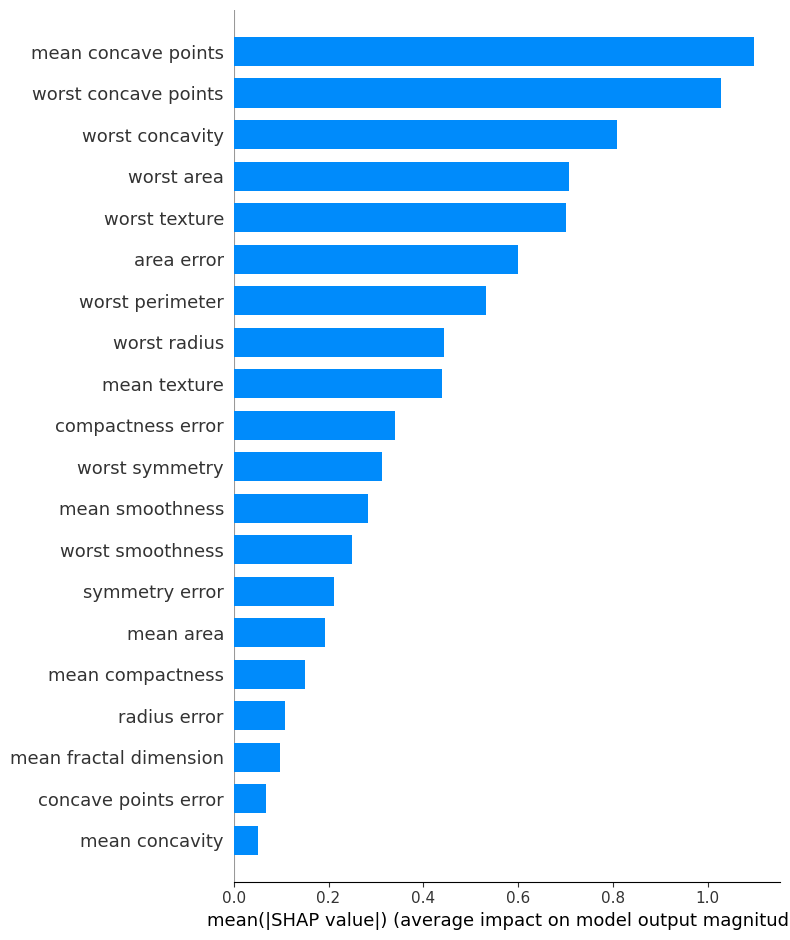

Пояснення моделі:
- Ознака **worst concave points** зі значенням **0.102** зменшує ймовірність (SHAP=-1.695)
- Ознака **worst texture** зі значенням **24.640** збільшує ймовірність позитивного класу (SHAP=1.572)
- Ознака **mean concave points** зі значенням **0.038** зменшує ймовірність (SHAP=-1.328)
- Ознака **worst area** зі значенням **677.900** зменшує ймовірність (SHAP=-0.838)
- Ознака **mean texture** зі значенням **18.600** збільшує ймовірність позитивного класу (SHAP=0.822)



In [11]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X.head()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X, plot_type="bar")

index = 0  # можна змінити
sample = X_test.iloc[index:index+1]

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], sample)

def explain_prediction(sample_index):
    sample = X_test.iloc[sample_index:sample_index+1]
    values = shap_values[sample_index]

    df = pd.DataFrame({
        "Feature": X.columns,
        "SHAP value": values,
        "Impact": ["Підвищує ризик" if v > 0 else "Знижує ризик" for v in values]
    }).sort_values(by="SHAP value", key=abs, ascending=False)

    return df.head(10)

explain_prediction(0)

def text_explanation(sample_index):
    sample = X_test.iloc[sample_index]
    shap_vals = shap_values[sample_index]

    top_i = np.argsort(np.abs(shap_vals))[-5:][::-1]

    explanation = "Пояснення моделі:\n"
    for i in top_i:
        feature = X.columns[i]
        val = sample.iloc[i]
        impact = shap_vals[i]

        direction = "збільшує ймовірність позитивного класу" if impact > 0 else "зменшує ймовірність"
        explanation += f"- Ознака **{feature}** зі значенням **{val:.3f}** {direction} (SHAP={impact:.3f})\n"

    return explanation

print(text_explanation(0))

